In [8]:
from model import Generator
from PIL import Image
import os
import torch
import time
import I
from torch.autograd import Variable
from torchvision.transforms import ToTensor, ToPILImage

In [9]:
torch.cuda.device_count()

0

In [13]:
upscale_factor = 8
if torch.cuda.device_count() == 0:
    test_mode = 'CPU'
if torch.cuda.device_count() != 0:
    test_mode = 'GPU'
model_name = '../weights/netG_epoch_8_100.pth'
TEST_MODE = False

In [14]:
model = Generator(upscale_factor).eval()

In [15]:
model = Generator(upscale_factor).eval()
if test_mode == 'GPU':
    model.cuda()
    model.load_state_dict(torch.load(model_name))
if test_mode == 'CPU':
    model.load_state_dict(torch.load(model_name, map_location=lambda storage, loc: storage))

In [16]:
path_super_resolution = "/home/damvantai/Documents/projects/deep_face_recognition/images/faces/super_resolution_102/"
path = "/home/damvantai/Downloads/faces_102/"

In [ ]:
start = time.time()
for file_image in os.listdir(path):
#     print(file_image)
    image = Image.open(path + file_image)
    image = Variable(ToTensor()(image), volatile=True).unsqueeze(0)
    if test_mode == 'GPU':
        image = image.cuda()
    out = model(image)
    out_img = ToPILImage()(out[0].data.cpu())
    out_img.save(path_super_resolution + str(upscale_factor) + '_' + file_image)
print("Time runtime: ", time.time() - start)

/home/damvantai/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  """
/home/damvantai/.local/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Use image super resolution for predict gender and age

In [24]:
import cv2
import numpy as np
import face_recognition
from PIL import Image
import glob
import re
import ntpath
import os
import dlib
import time
# from resizeimage import resizeimage
from PIL import Image
from imutils.face_utils import FaceAligner
import sqlite3
from imutils.face_utils import rect_to_bb
import imutils
from imutils import face_utils
import os
import shutil
import inception_resnet_v1
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime
# import pymysql as MySQLdb
import math
from imutils.video import VideoStream

In [38]:
# Load model and run graph inception resnet v1 from models and file resnetv1_inception.py
tf.reset_default_graph() 
sess = tf.InteractiveSession()
sess = tf.Session()
images_pl = tf.placeholder(tf.float32, shape=[None, 160, 160, 3], name='input_image')
images_norm = tf.map_fn(lambda frame: tf.image.per_image_standardization(frame), images_pl)
train_mode = tf.placeholder(tf.bool)
age_logits, gender_logits, _ = inception_resnet_v1.inference(images_norm, keep_probability=0.8,
                                                             phase_train=train_mode,
                                                             weight_decay=1e-5)

# print(gender_logits.shape)
gender = tf.argmax(tf.nn.softmax(gender_logits), 1)
age_ = tf.cast(tf.constant([i for i in range(0, 101)]), tf.float32)
age = tf.reduce_sum(tf.multiply(tf.nn.softmax(age_logits), age_), axis=1)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())
sess.run(init_op)
saver = tf.train.Saver()
ckpt = tf.train.get_checkpoint_state("models_gender_and_age/")
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("restore model!")
else:
    pass


In [39]:
faces = np.empty((1,160, 160, 3))

[47.] [0]
[[6358.9727    76.66785]]
47, F


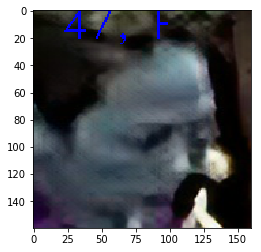

In [40]:
# path = "/home/neosai/Downloads/face/"
path = "/home/neosai/Documents/projects/deep_face_recognition/image/103/id_9, 35, Male.jpg"

face1 = Image.open(path)
face_male_resize1 = face1.resize((160, 160), Image.ANTIALIAS)
face1 = np.array(face_male_resize1)
faces[0, :, :, :] = face1
age_predict, gender_predict, gender1 = sess.run([age, gender, gender_logits], feed_dict={images_pl: faces, train_mode: False})
print(age_predict, gender_predict)
print(gender1)

label = "{}, {}".format(int(age_predict[0]), "F" if gender_predict[0] == 0 else "M")
face = cv2.putText(face1, label, (20, 20), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 0, 0))
face = cv2.cvtColor(face1, cv2.COLOR_RGB2BGR)
plt.imshow(face)
print(label)

In [41]:
face.shape

(160, 160, 3)

In [42]:
faces[0, :, :, :] 

array([[[28., 44., 44.],
        [30., 47., 46.],
        [35., 50., 50.],
        ...,
        [24., 31., 42.],
        [24., 30., 42.],
        [24., 30., 42.]],

       [[24., 38., 39.],
        [28., 42., 43.],
        [33., 47., 48.],
        ...,
        [23., 30., 42.],
        [23., 29., 41.],
        [22., 28., 40.]],

       [[16., 30., 31.],
        [19., 33., 34.],
        [24., 38., 39.],
        ...,
        [23., 29., 40.],
        [21., 28., 38.],
        [20., 27., 37.]],

       ...,

       [[82., 22., 58.],
        [82., 21., 59.],
        [84., 22., 62.],
        ...,
        [ 0.,  1., 12.],
        [ 1.,  3., 17.],
        [ 3.,  5., 20.]],

       [[85., 25., 61.],
        [85., 25., 62.],
        [86., 26., 66.],
        ...,
        [ 0.,  2., 13.],
        [ 2.,  4., 18.],
        [ 4.,  6., 21.]],

       [[90., 30., 66.],
        [89., 29., 65.],
        [89., 29., 65.],
        ...,
        [ 1.,  3., 14.],
        [ 3.,  5., 19.],
        [ 4.,  6., 21.]]

In [43]:
len(faces)

1

[47.] [0]
[[5211.3438   127.18616]]
47, F


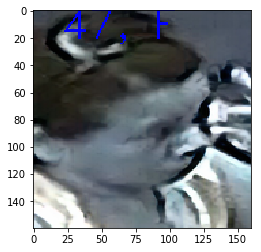

In [45]:
faces = []
# path = "/home/neosai/Downloads/face/"
path = "/home/neosai/Documents/projects/deep_face_recognition/image/103/id_10, 30, Male.jpg"

face2 = Image.open(path)
face_male_resize2 = face2.resize((160, 160), Image.ANTIALIAS)
face2 = np.array(face_male_resize2)
faces.append(face2)
age_predict, gender_predict, gender1 = sess.run([age, gender, gender_logits], feed_dict={images_pl: faces, train_mode: False})
print(age_predict, gender_predict)
print(gender1)

label = "{}, {}".format(int(age_predict[0]), "F" if gender_predict[0] == 0 else "M")
face2 = cv2.putText(face2, label, (20, 20), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 0, 0))
face2 = cv2.cvtColor(face2, cv2.COLOR_RGB2BGR)
plt.imshow(face2)
print(label)

In [23]:
path = "/home/neosai/Documents/projects/deep_face_recognition/image/103/"
id_number = 0
for i in os.listdir(path):
    face = Image.open(path + i)
#     print(path + i)
    face_male_resize = face.resize((160, 160), Image.ANTIALIAS)
    face = np.array(face_male_resize)
    faces.append(face)
    age_predict, gender_predict = sess.run([age, gender], feed_dict={images_pl: faces, train_mode: False})
    label = "{}, {}".format(int(age_predict[0]), "F" if gender_predict[0] == 0 else "M")
    face = cv2.putText(face, label, (20, 20), cv2.FONT_HERSHEY_DUPLEX, 1, (255, 0, 0))
    face = cv2.cvtColor(face, cv2.COLOR_RGB2BGR)
    filename = str(id_number) + "_" + label
    print(filename)
    cv2.imwrite("/home/neosai/Documents/projects/deep_face_recognition/image/103_predicted/%s.jpg"%filename, face)
    id_number += 1
    faces = []

0_57, M
1_57, M
2_57, M
3_57, M
4_57, M
5_57, M
6_57, M
7_57, M
8_57, M
9_57, M
10_57, M
11_57, M
12_57, M
13_57, M
14_57, M
15_57, M
16_57, M
17_57, M
18_57, M
19_57, M
20_57, M
21_57, M
22_57, M
23_57, M
24_57, M
25_57, M
26_57, M
27_57, M
28_57, M
29_57, M
30_57, M
31_57, M
32_57, M
33_57, M
34_57, M
35_57, M
36_57, M
37_57, M
38_57, M
39_57, M
40_57, M
41_57, M
42_57, M
43_57, M
44_57, M
45_57, M
46_57, M
47_57, M
48_57, M
49_57, M
50_57, M
51_57, M
52_57, M
53_57, M
54_57, M
55_57, M
56_57, M
57_57, M
58_57, M
59_57, M
60_57, M
61_57, M
62_57, M
63_57, M
64_57, M
65_57, M
66_57, M
67_57, M
68_57, M
69_57, M
70_57, M
71_57, M
72_57, M
73_57, M
74_57, M
75_57, M
76_57, M
77_57, M
78_57, M
79_57, M
80_57, M
81_57, M
82_57, M
83_57, M
84_57, M
85_57, M
86_57, M
87_57, M
88_57, M
89_57, M
90_57, M
91_57, M
92_57, M
93_57, M
94_57, M
95_57, M
96_57, M
97_57, M
98_57, M
99_57, M
100_57, M
101_57, M
102_57, M
103_57, M
104_57, M
105_57, M
106_57, M
107_57, M
108_57, M
109_57, M
110_57, M


## Test

In [23]:
from os import listdir
from os.path import join
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [24]:
def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])

In [25]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])

In [26]:
def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)

In [27]:
def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])

In [28]:
def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])

In [29]:
def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

In [30]:
class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [40]:
train_set = TrainDatasetFromFolder('/home/damvantai/Downloads/', crop_size=88, upscale_factor=4)
train_set.__getitem__(1).size

AttributeError: 'tuple' object has no attribute 'size'

In [ ]:
image_path = "/home/neosai/Downloads/face/46402_1951-02-15_2009.jpg"